In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.2.2+cu121
True


In [2]:
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision.io import read_image

torch.device("cuda")

device(type='cuda')

In [3]:
from torchvision import transforms
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

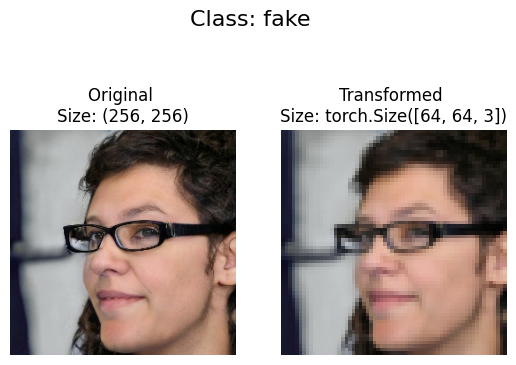

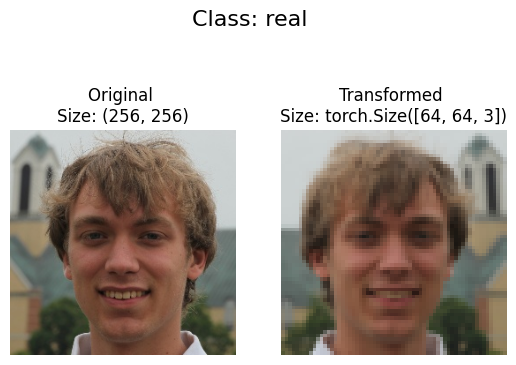

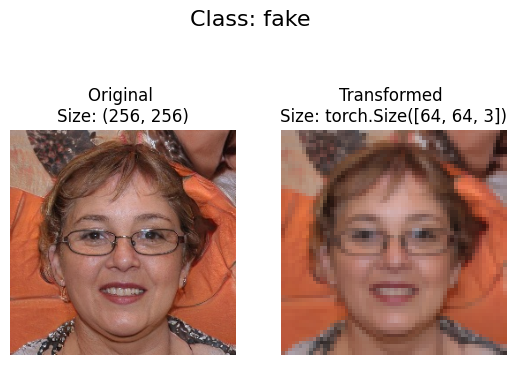

In [4]:
import random
from PIL import Image
from pathlib import Path


random.seed(42)

data_path = Path("RealvsFake_Face/")
image_path = data_path / "rvf10k"
train_dir = image_path / "train"
test_dir = image_path / "valid"
image_path_list = list(image_path.glob("*/*/*.jpg"))

def plot_transformed_images(image_paths, transform, n=5, seed=11):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

In [5]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

In [6]:
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size,shuffle=True, num_workers=10,pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=True, num_workers=10,pin_memory=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([32, 3, 64, 64])
Shape of y: torch.Size([32]) torch.int64


In [7]:
import torch.optim as optim
from sklearn.metrics import classification_report

def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(torch.device('cuda')), labels.to(torch.device('cuda'))
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
                
    print('\nAccuracy on the test set: %d %%' % (100 * correct / total))
    report = classification_report(all_labels, all_predictions, digits=4)
    print("Classification Report:")
    print(report)

def test_model2(model, test_loader, num_examples=5):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(torch.device('cuda')), labels.to(torch.device('cuda'))
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
                
    accuracy = 100 * correct / total
    report = classification_report(all_labels, all_predictions, digits=4)
    
    # Plotting accuracy
    plt.figure(figsize=(8, 6))
    plt.bar(['Correct', 'Incorrect'], [correct, total - correct], color=['green', 'red'])
    plt.title('Accuracy on the test set')
    plt.xlabel('Prediction')
    plt.ylabel('Count')
    plt.show()
    
    print('Accuracy on the test set: %.2f %%' % accuracy)
    print("Classification Report:")
    print(report)
    
    # Example predictions
    print("\nExample Predictions:")
    for i in range(num_examples):
        example_input, example_label = next(iter(test_loader))
        example_input = example_input[0].unsqueeze(0).to(torch.device('cuda'))
        example_output = model(example_input)
        _, example_prediction = torch.max(example_output.data, 1)
        
        # Display example input as an image
        plt.figure()
        plt.imshow(example_input.cpu().numpy().squeeze().transpose(1, 2, 0))  # Assuming input is in NCHW format
        plt.title("Example Input")
        plt.axis('off')
        plt.show()
        
        t = example_prediction.item()
        if t==1:
            t = "Real"
        else:
            t = "Fake"
        print("Predicted Label:", t)
        print()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.c1 = nn.Conv2d(3,6,kernel_size=3)
        self.c2 = nn.Conv2d(6,16,kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(3136,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,2)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten(1)
    def forward(self,x):
        x = self.pool(self.relu(self.c1(x)))
        x = self.pool(self.relu(self.c2(x)))
        x = self.flat(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
model1 = LeNet()
model1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.0001)

torch.cuda.empty_cache()
train_model(model1,train_dataloader, criterion, optimizer, num_epochs=15)
torch.cuda.empty_cache()
test_model(model1,test_dataloader)

Epoch 1/15, Loss: 0.6876965140643185
Epoch 2/15, Loss: 0.6599023957230729
Epoch 3/15, Loss: 0.6363469487455882
Epoch 4/15, Loss: 0.6193725781081474
Epoch 5/15, Loss: 0.5972890444270008
Epoch 6/15, Loss: 0.5788007744643242
Epoch 7/15, Loss: 0.5694070428473764
Epoch 8/15, Loss: 0.5513216397261511
Epoch 9/15, Loss: 0.5437943260419315
Epoch 10/15, Loss: 0.5316595537205265
Epoch 11/15, Loss: 0.5227955347054625
Epoch 12/15, Loss: 0.512087600552328
Epoch 13/15, Loss: 0.5066028626542113
Epoch 14/15, Loss: 0.496680349111557
Epoch 15/15, Loss: 0.48679963910960716

Accuracy on the test set: 76 %
Classification Report:
              precision    recall  f1-score   support

           0     0.7757    0.7353    0.7550      1500
           1     0.7484    0.7873    0.7674      1500

    accuracy                         0.7613      3000
   macro avg     0.7620    0.7613    0.7612      3000
weighted avg     0.7620    0.7613    0.7612      3000



In [10]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        self.c1 = nn.Conv2d(3,64,kernel_size=11,stride=4,padding=2)
        self.c2 = nn.Conv2d(64,192,kernel_size=5,padding=2)
        self.c3 = nn.Conv2d(192,384,kernel_size=3,padding=1)
        self.c4 = nn.Conv2d(384,256,kernel_size=3,padding=1)
        self.c5 = nn.Conv2d(256,256,kernel_size=3,padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3,stride=2)
        self.fc1 = nn.Linear(256*6*6,4096)
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,2)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten(1)
        self.drop = nn.Dropout()
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
    def forward(self,x):
        x = self.pool(self.relu((self.c1(x))))
        x = self.pool(self.relu((self.c2(x))))
        x = self.relu((self.c3(x)))
        x = self.relu((self.c4(x)))
        x = self.relu((self.c5(x)))
        x = self.pool(x)
        x = self.avgpool(x)
        x = self.flat(x)
        x = self.relu(self.fc1(self.drop(x)))
        x = self.relu(self.fc2(self.drop(x)))
        x = self.fc3(x)
        return x

In [11]:
model2 = AlexNet()
model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.0001)

torch.cuda.empty_cache()
train_model(model2,train_dataloader, criterion, optimizer, num_epochs=15)
torch.cuda.empty_cache()
test_model(model2,test_dataloader)

Epoch 1/15, Loss: 0.6939098848599822
Epoch 2/15, Loss: 0.6699131227791582
Epoch 3/15, Loss: 0.5927557366895894
Epoch 4/15, Loss: 0.5437546613281721
Epoch 5/15, Loss: 0.5161336320175972
Epoch 6/15, Loss: 0.4910948284684795
Epoch 7/15, Loss: 0.45550277774736764
Epoch 8/15, Loss: 0.41960401030163785
Epoch 9/15, Loss: 0.3926594890143773
Epoch 10/15, Loss: 0.36731624793788614
Epoch 11/15, Loss: 0.3344220240094346
Epoch 12/15, Loss: 0.31141723634581586
Epoch 13/15, Loss: 0.27557873555786533
Epoch 14/15, Loss: 0.25292699409810376
Epoch 15/15, Loss: 0.2301764664278455

Accuracy on the test set: 78 %
Classification Report:
              precision    recall  f1-score   support

           0     0.7871    0.7840    0.7856      1500
           1     0.7849    0.7880    0.7864      1500

    accuracy                         0.7860      3000
   macro avg     0.7860    0.7860    0.7860      3000
weighted avg     0.7860    0.7860    0.7860      3000



In [12]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class InceptionModule(nn.Module):
    def __init__(self, in_channels, conv1x1, conv3x3_reduce, conv3x3, conv5x5_reduce, conv5x5, pool_proj):
        super(InceptionModule, self).__init__()
        self.branch1 = BasicConv2d(in_channels, conv1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, conv3x3_reduce, kernel_size=1),
            BasicConv2d(conv3x3_reduce, conv3x3, kernel_size=3, padding=1)
        )
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, conv5x5_reduce, kernel_size=1),
            BasicConv2d(conv5x5_reduce, conv5x5, kernel_size=5, padding=2)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)

class InceptionV1(nn.Module):
    def __init__(self):
        super(InceptionV1, self).__init__()
        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)

        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)

        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [13]:
model3 = InceptionV1()
model3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.0001)

torch.cuda.empty_cache()
train_model(model3,train_dataloader, criterion, optimizer, num_epochs=15)
torch.cuda.empty_cache()
test_model(model3,test_dataloader)

Epoch 1/15, Loss: 0.6981236014736297
Epoch 2/15, Loss: 0.6294429536279478
Epoch 3/15, Loss: 0.5725721644756456
Epoch 4/15, Loss: 0.5190414139941403
Epoch 5/15, Loss: 0.47650408493057234
Epoch 6/15, Loss: 0.4221770574240924
Epoch 7/15, Loss: 0.37905109792811686
Epoch 8/15, Loss: 0.34208128108009356
Epoch 9/15, Loss: 0.29307356337297996
Epoch 10/15, Loss: 0.2560378922038971
Epoch 11/15, Loss: 0.23141668444354785
Epoch 12/15, Loss: 0.21209565495655416
Epoch 13/15, Loss: 0.19293641987932872
Epoch 14/15, Loss: 0.171934260472179
Epoch 15/15, Loss: 0.1427956483662809

Accuracy on the test set: 77 %
Classification Report:
              precision    recall  f1-score   support

           0     0.8202    0.6933    0.7514      1500
           1     0.7344    0.8480    0.7871      1500

    accuracy                         0.7707      3000
   macro avg     0.7773    0.7707    0.7693      3000
weighted avg     0.7773    0.7707    0.7693      3000



In [14]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 2),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [15]:
model4 = VGG16()
model4.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters(), lr=0.0001)

torch.cuda.empty_cache()
train_model(model4,train_dataloader, criterion, optimizer, num_epochs=15)
torch.cuda.empty_cache()
test_model(model4,test_dataloader)

Epoch 1/15, Loss: 0.6935601484829976
Epoch 2/15, Loss: 0.6934396806917235
Epoch 3/15, Loss: 0.6932463762967009
Epoch 4/15, Loss: 0.6935607643976603
Epoch 5/15, Loss: 0.6932692103189965
Epoch 6/15, Loss: 0.6932782958087311
Epoch 7/15, Loss: 0.6933651512071967
Epoch 8/15, Loss: 0.6933755349350846
Epoch 9/15, Loss: 0.6932255097720177
Epoch 10/15, Loss: 0.693226841214585
Epoch 11/15, Loss: 0.6932679719576552
Epoch 12/15, Loss: 0.6933558711178227
Epoch 13/15, Loss: 0.6932521682896026
Epoch 14/15, Loss: 0.6932884890194897
Epoch 15/15, Loss: 0.6931450726234749

Accuracy on the test set: 50 %
Classification Report:
              precision    recall  f1-score   support

           0     0.5000    1.0000    0.6667      1500
           1     0.0000    0.0000    0.0000      1500

    accuracy                         0.5000      3000
   macro avg     0.2500    0.5000    0.3333      3000
weighted avg     0.2500    0.5000    0.3333      3000



c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [16]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = nn.ReLU()(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, 2)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.AdaptiveAvgPool2d((1, 1))(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

# Define ResNet-50 model
def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


In [17]:
model5 = ResNet50()
model5.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model5.parameters(), lr=0.0001)

torch.cuda.empty_cache()
train_model(model5,train_dataloader, criterion, optimizer, num_epochs=15)
torch.cuda.empty_cache()
test_model(model5,test_dataloader)

Epoch 1/15, Loss: 0.7242059182358659
Epoch 2/15, Loss: 0.6507494641493444
Epoch 3/15, Loss: 0.5952735069679888
Epoch 4/15, Loss: 0.554801525862794
Epoch 5/15, Loss: 0.4991335774257303
Epoch 6/15, Loss: 0.4671961308614304
Epoch 7/15, Loss: 0.4071796087369527
Epoch 8/15, Loss: 0.3752588107161326
Epoch 9/15, Loss: 0.34256411183914637
Epoch 10/15, Loss: 0.32283981294120284
Epoch 11/15, Loss: 0.274645515177484
Epoch 12/15, Loss: 0.24674449952906125
Epoch 13/15, Loss: 0.23553718116185438
Epoch 14/15, Loss: 0.20557998660016277
Epoch 15/15, Loss: 0.20082815076526442

Accuracy on the test set: 75 %
Classification Report:
              precision    recall  f1-score   support

           0     0.7393    0.7960    0.7666      1500
           1     0.7791    0.7193    0.7480      1500

    accuracy                         0.7577      3000
   macro avg     0.7592    0.7577    0.7573      3000
weighted avg     0.7592    0.7577    0.7573      3000



In [18]:
class AlexNetv2(nn.Module):
    def __init__(self):
        super(AlexNetv2,self).__init__()
        self.c1 = nn.Conv2d(3,64,kernel_size=11,stride=4,padding=2)
        self.b1 = nn.BatchNorm2d(64)
        self.c2 = nn.Conv2d(64,192,kernel_size=5,padding=2)
        self.b2 = nn.BatchNorm2d(192)
        self.c3 = nn.Conv2d(192,384,kernel_size=3,padding=1)
        self.b3 = nn.BatchNorm2d(384)
        self.c4 = nn.Conv2d(384,256,kernel_size=3,padding=1)
        self.b4 = nn.BatchNorm2d(256)
        self.c5 = nn.Conv2d(256,256,kernel_size=3,padding=1)
        self.b5 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=3,stride=2)
        self.fc1 = nn.Linear(256*6*6,4096)
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,2)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten(1)
        self.drop = nn.Dropout()
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
    def forward(self,x):
        x = self.pool(self.relu(self.b1(self.c1(x))))
        x = self.pool(self.relu(self.b2(self.c2(x))))
        x = self.relu(self.b3(self.c3(x)))
        x = self.relu(self.b4(self.c4(x)))
        x = self.relu(self.b5(self.c5(x)))
        x = self.pool(x)
        x = self.avgpool(x)
        x = self.flat(x)
        x = self.relu(self.fc1(self.drop(x)))
        x = self.relu(self.fc2(self.drop(x)))
        x = self.fc3(x)
        return x

In [19]:
model6 = AlexNetv2()
model6.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model6.parameters(), lr=0.0001)

torch.cuda.empty_cache()
train_model(model6,train_dataloader, criterion, optimizer, num_epochs=15)
torch.cuda.empty_cache()
test_model(model6,test_dataloader)

Epoch 1/15, Loss: 0.7070040766779147
Epoch 2/15, Loss: 0.5625470777352651
Epoch 3/15, Loss: 0.5143273789860886
Epoch 4/15, Loss: 0.482733897286463
Epoch 5/15, Loss: 0.4441759981657272
Epoch 6/15, Loss: 0.4097802276344604
Epoch 7/15, Loss: 0.37264397869643556
Epoch 8/15, Loss: 0.35628691819160496
Epoch 9/15, Loss: 0.3188290120055686
Epoch 10/15, Loss: 0.302813214458287
Epoch 11/15, Loss: 0.2848048985820927
Epoch 12/15, Loss: 0.24010201739189832
Epoch 13/15, Loss: 0.22572478293079765
Epoch 14/15, Loss: 0.19885877608300345
Epoch 15/15, Loss: 0.185209292595245

Accuracy on the test set: 72 %
Classification Report:
              precision    recall  f1-score   support

           0     0.6569    0.9447    0.7750      1500
           1     0.9015    0.5067    0.6487      1500

    accuracy                         0.7257      3000
   macro avg     0.7792    0.7257    0.7118      3000
weighted avg     0.7792    0.7257    0.7118      3000



LeNet


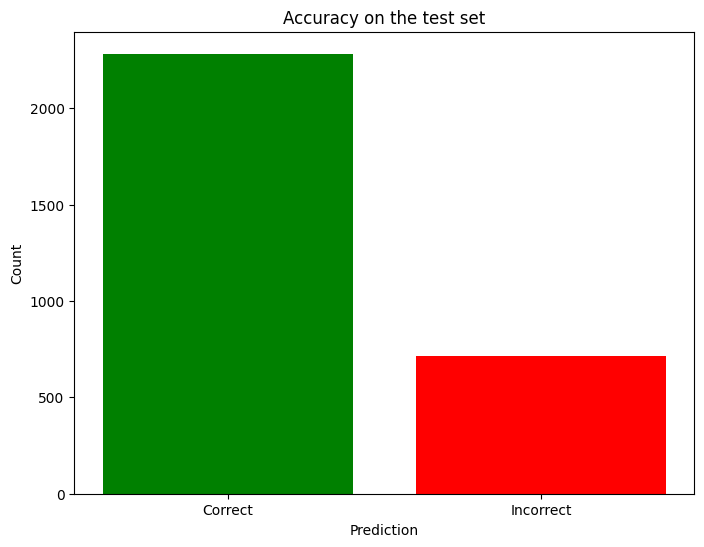

Accuracy on the test set: 76.10 %
Classification Report:
              precision    recall  f1-score   support

           0     0.7740    0.7373    0.7552      1500
           1     0.7492    0.7847    0.7665      1500

    accuracy                         0.7610      3000
   macro avg     0.7616    0.7610    0.7609      3000
weighted avg     0.7616    0.7610    0.7609      3000


Example Predictions:


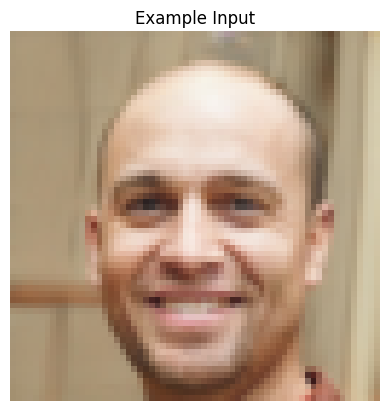

Predicted Label: Fake



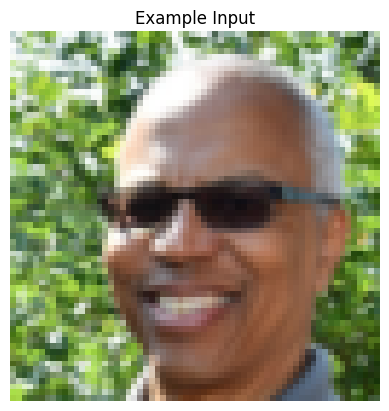

Predicted Label: Real



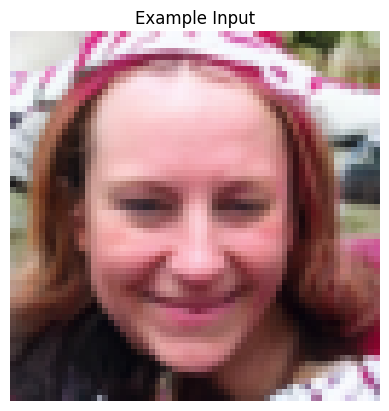

Predicted Label: Fake



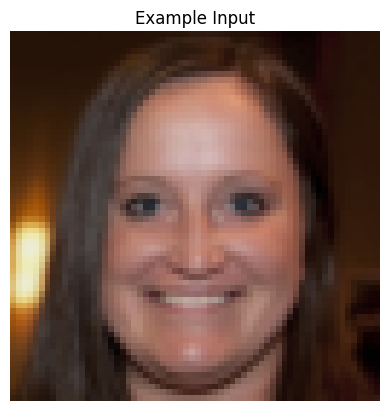

Predicted Label: Fake



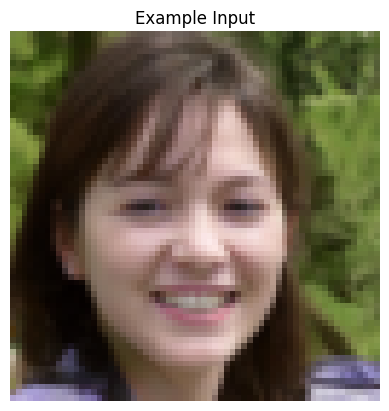

Predicted Label: Fake

AlexNet


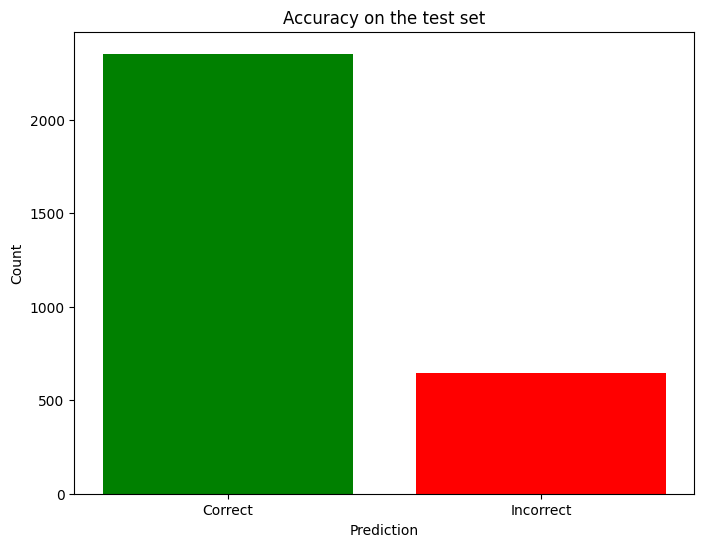

Accuracy on the test set: 78.47 %
Classification Report:
              precision    recall  f1-score   support

           0     0.7850    0.7840    0.7845      1500
           1     0.7843    0.7853    0.7848      1500

    accuracy                         0.7847      3000
   macro avg     0.7847    0.7847    0.7847      3000
weighted avg     0.7847    0.7847    0.7847      3000


Example Predictions:


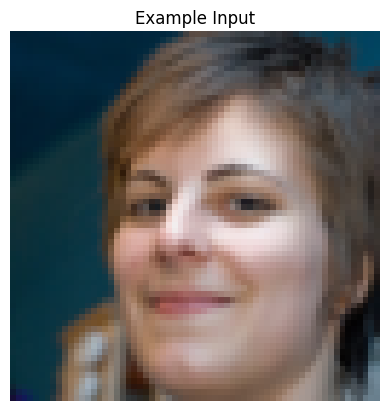

Predicted Label: Real



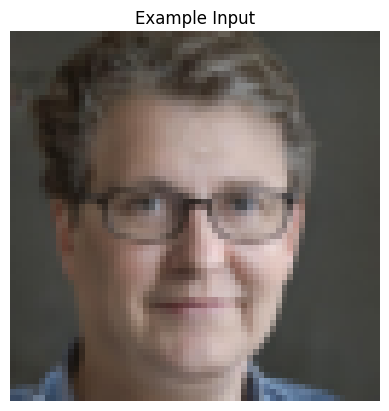

Predicted Label: Fake



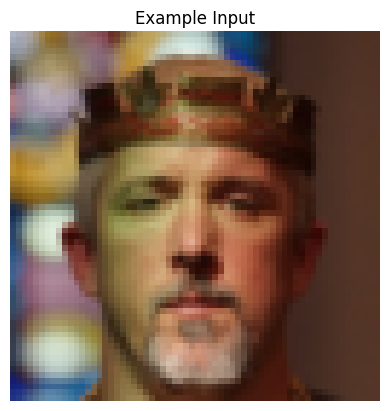

Predicted Label: Real



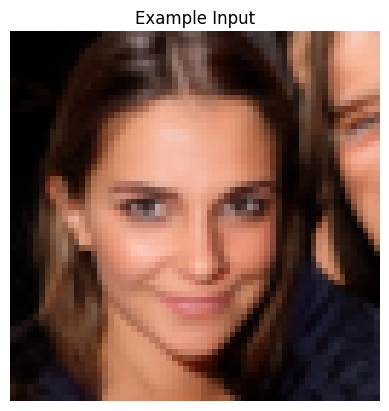

Predicted Label: Fake



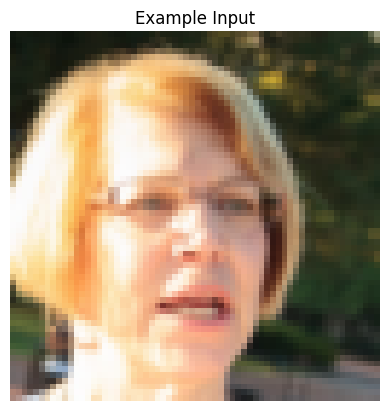

Predicted Label: Real

InceptionV1


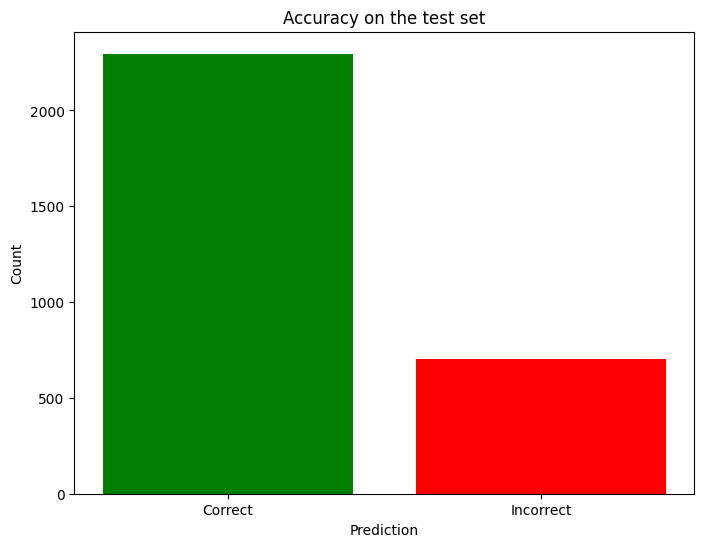

Accuracy on the test set: 76.53 %
Classification Report:
              precision    recall  f1-score   support

           0     0.8184    0.6820    0.7440      1500
           1     0.7274    0.8487    0.7834      1500

    accuracy                         0.7653      3000
   macro avg     0.7729    0.7653    0.7637      3000
weighted avg     0.7729    0.7653    0.7637      3000


Example Predictions:


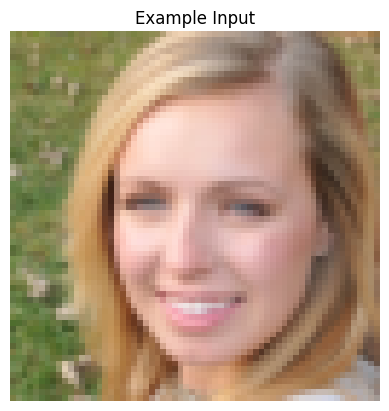

Predicted Label: Real



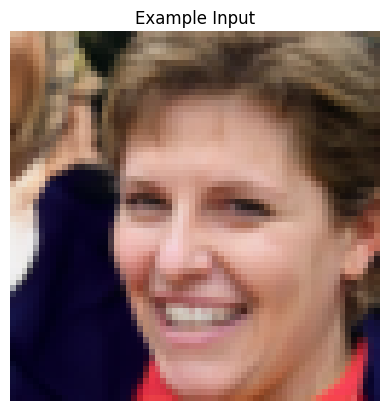

Predicted Label: Real



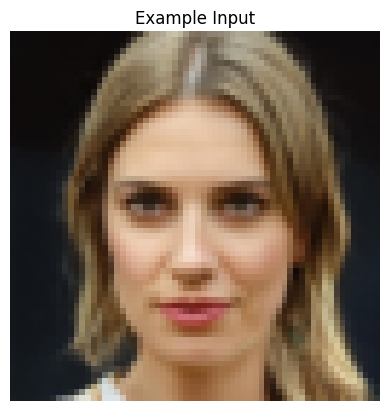

Predicted Label: Fake



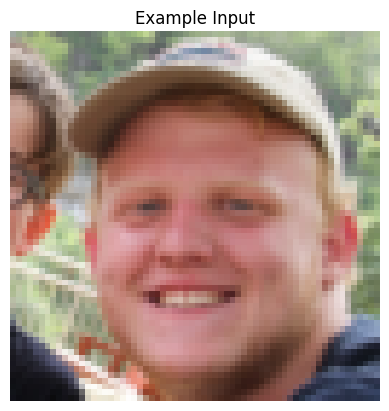

Predicted Label: Real



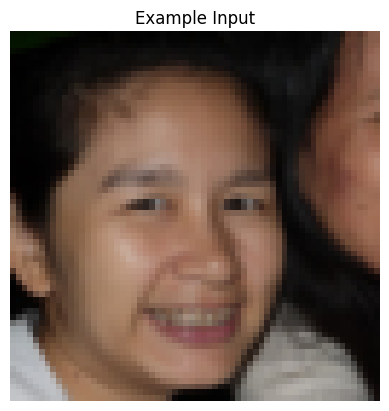

Predicted Label: Real

VGG16


c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

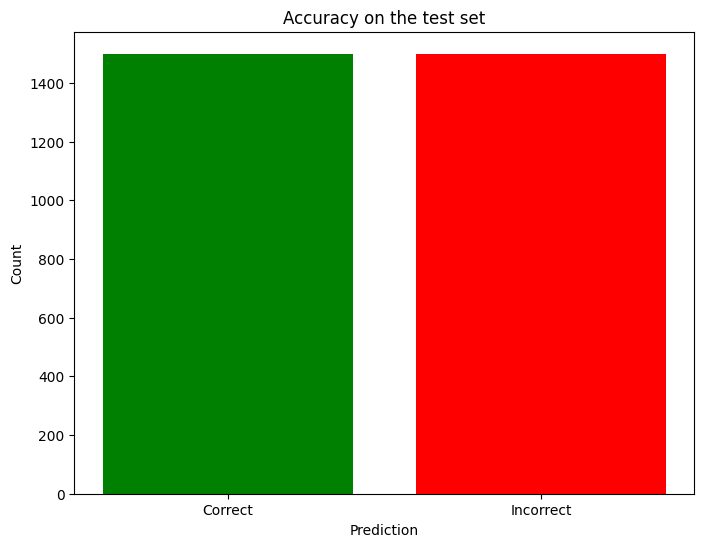

Accuracy on the test set: 50.00 %
Classification Report:
              precision    recall  f1-score   support

           0     0.5000    1.0000    0.6667      1500
           1     0.0000    0.0000    0.0000      1500

    accuracy                         0.5000      3000
   macro avg     0.2500    0.5000    0.3333      3000
weighted avg     0.2500    0.5000    0.3333      3000


Example Predictions:


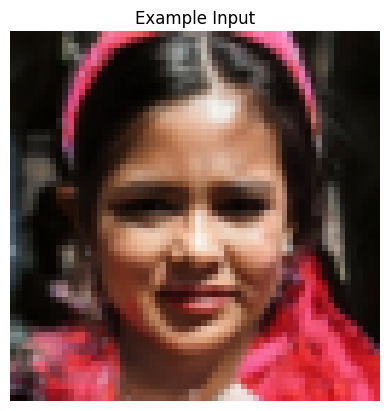

Predicted Label: Fake



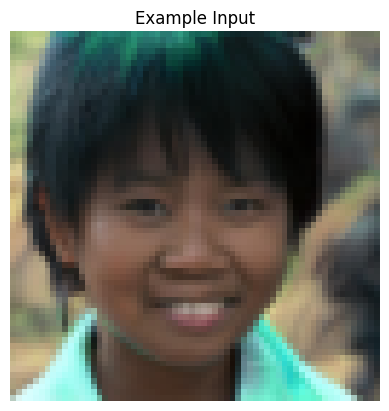

Predicted Label: Fake



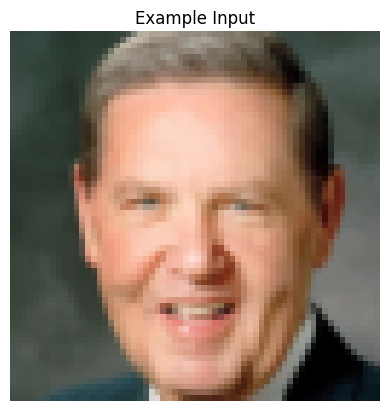

Predicted Label: Fake



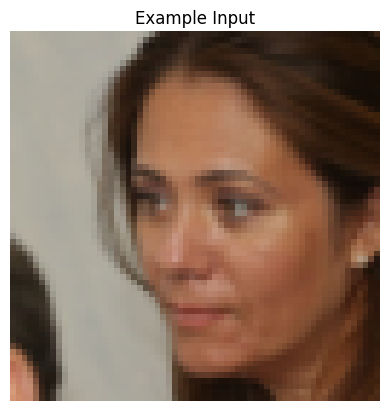

Predicted Label: Fake



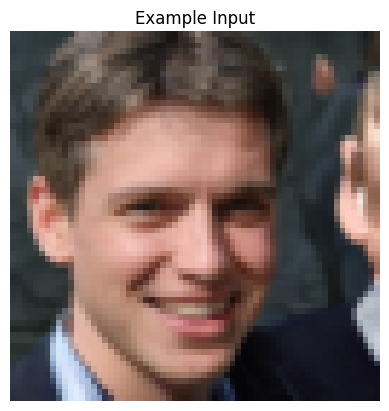

Predicted Label: Fake

ResNet


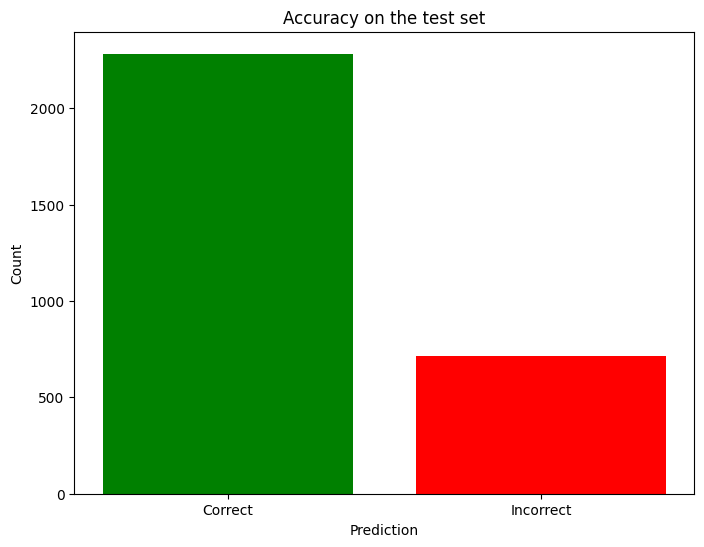

Accuracy on the test set: 76.10 %
Classification Report:
              precision    recall  f1-score   support

           0     0.7433    0.7973    0.7694      1500
           1     0.7815    0.7247    0.7520      1500

    accuracy                         0.7610      3000
   macro avg     0.7624    0.7610    0.7607      3000
weighted avg     0.7624    0.7610    0.7607      3000


Example Predictions:


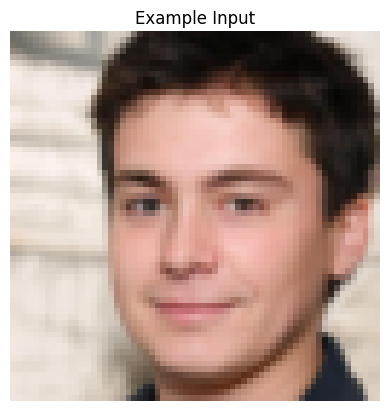

Predicted Label: Fake



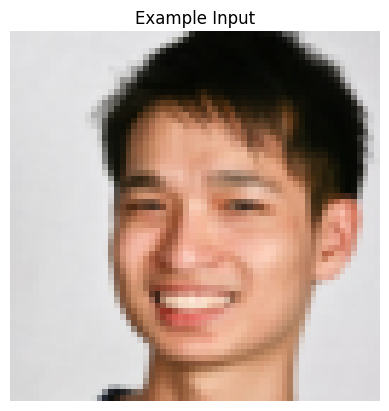

Predicted Label: Fake



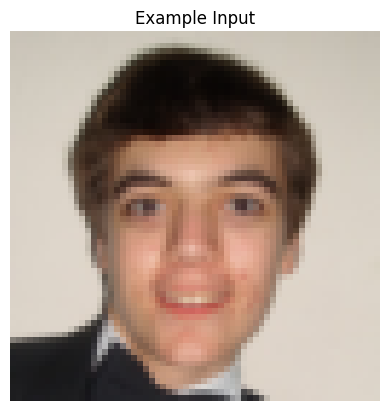

Predicted Label: Fake



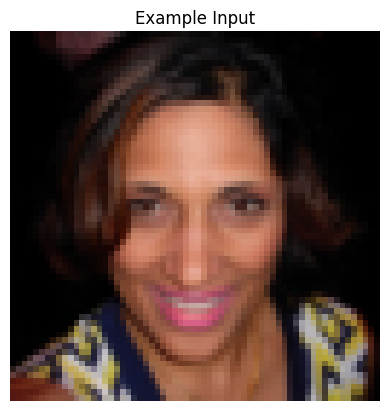

Predicted Label: Fake



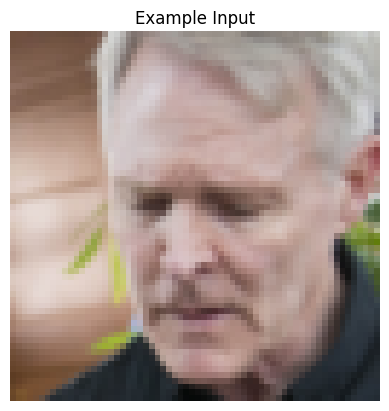

Predicted Label: Real

AlexNetv2


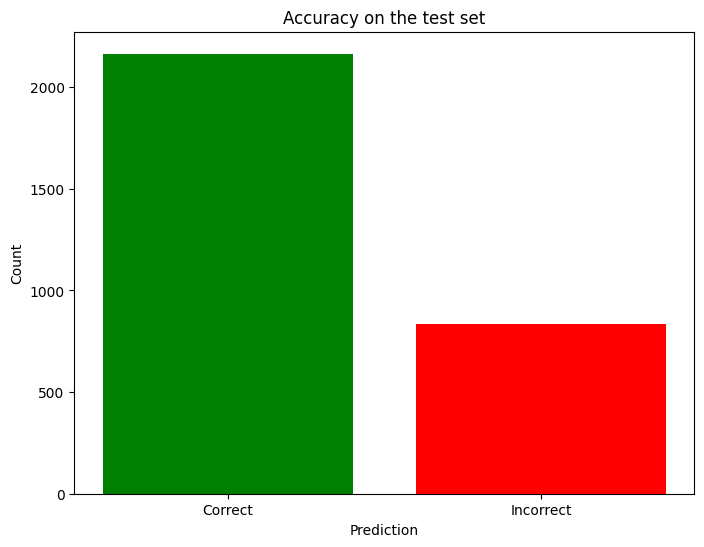

Accuracy on the test set: 72.17 %
Classification Report:
              precision    recall  f1-score   support

           0     0.6532    0.9453    0.7725      1500
           1     0.9011    0.4980    0.6415      1500

    accuracy                         0.7217      3000
   macro avg     0.7771    0.7217    0.7070      3000
weighted avg     0.7771    0.7217    0.7070      3000


Example Predictions:


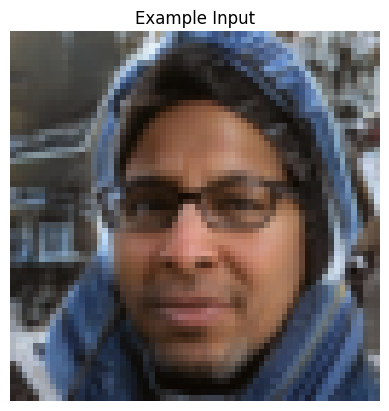

Predicted Label: Fake



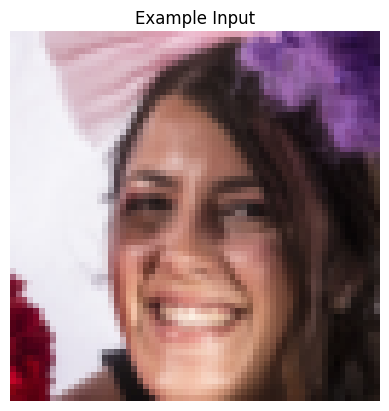

Predicted Label: Real



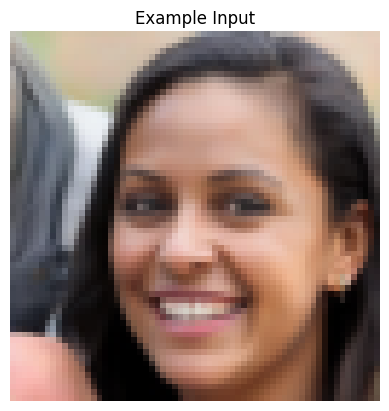

Predicted Label: Fake



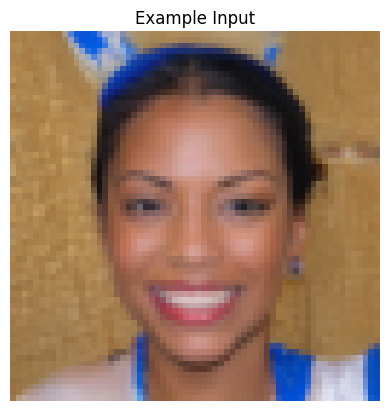

Predicted Label: Fake



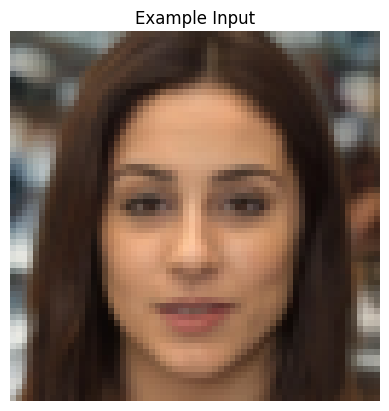

Predicted Label: Fake



In [22]:
print("LeNet")
test_model2(model1, test_dataloader)
print("AlexNet")
test_model2(model2, test_dataloader)
print("InceptionV1")
test_model2(model3, test_dataloader)
print("VGG16")
test_model2(model4, test_dataloader)
print("ResNet")
test_model2(model5, test_dataloader)
print("AlexNetv2")
test_model2(model6, test_dataloader)